 # Opis notatnika
 Ten notatnik jest kontynuacją analizy danych o lotach i ich opóźnieniach.

 Import bibliotek:

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
import matplotlib.pyplot as plt

 ## Połączenie z bazą danych

In [2]:
username = 'postgres'
password='al2cx7hsixj',  # Przypadkowe, nieprawdziwe hasło
host = 'localhost'
database = 'airlines'
port = 5432

 Tworzenie zmiennej engine, która zostanie użyta do połączenia z bazą danych

In [2]:
url = URL.create(
    "postgresql",
    username="postgres",
    password='al2cx7hsixj',  # Przypadkowe, nieprawdziwe hasło 
    host="localhost",
    database="airlines",
)
engine = create_engine(url)

 Zaczytanie zapisanej wcześniej ramki danych `flight_df` do zmniennej o takiej samej nazwie

In [4]:
flight_df = pd.read_csv(r'C:\Coderslab_Analityk_kurs\Projekt_koncowy\data\processed\flight_df_01.csv')

 # Wzbogacenie o `aircraft`
 Używając procedury `read_sql_table` należy wczytać dane z tabeli `aircraft` i zapisz jako `aircraft_df`. Następnie:  
 1. Usunąć z ramki kolumny `number_of_seats` oraz `id`. Na tej podstawie usuń także nadmiarowe wiersze (duplikaty).  
 1. Należy sprawdzić, czy dla jednego `tail_num` występuje więcej niż jeden rok produkcji.  
 1. Jeśli tak to:  
     - do ramki `aircraft_df_duplicated` zapisz powielone zgodnie ze sprawdzeniem wiersze,  
     - zgodnie z powyższym zmodyfikuj ramkę tak, aby w przypadku duplikatu za datę wytworzenia samolotu, uznana została najnowsza tj. jeśli dla `tail_num` są dostępne daty produkcji 1998 oraz 2001, uznajemy, że `tail_num` został wyprodukowany w `2001`.

 Wczytanie tabeli `aircraft` używając `read_sql_table`

In [6]:
aircraft_df = pd.read_sql_table('aircraft', con=engine,)

 Usunięcie kolumny `number_of_seats`, `id` oraz duplikatów z ramki `aircraft_df`

In [7]:
# Usunięcie kolumn number_of_seats i id:

aircraft_df = aircraft_df.drop(columns=['number_of_seats', 'id'])


# Usunięcie duplikatów:

aircraft_df = aircraft_df.drop_duplicates()

Sprawdzenie, czy w ramce `aircraft_df` występują duplikaty wewnątrz kolumny `tail_num`. Czyli czy dla danego `tail_num` występuje więcej niż jeden rok produkcji.

In [9]:
aircraft_df_is_duplicated = aircraft_df.duplicated(subset='tail_num')
aircraft_df_duplicated = aircraft_df.loc[aircraft_df_is_duplicated]

 ## Modyfikacja `aircraft_df`
 Aktualizacja tabeli `aircraft_df`

In [11]:
# Uszeregowanie pod względem daty, aby później zostawić tylko najpóźniejszą:

aircraft_df = aircraft_df.sort_values(by=['manufacture_year'])


# Usunięcie duplikatów zachowując ostatnie pojawienie się, a więc z najwyższą datą:

aircraft_df = aircraft_df.drop_duplicates(subset=['tail_num'], keep='last')


# Posortowanie z powrotem po indeksie:

aircraft_df = aircraft_df.sort_index()

 ## Połączenie `aircraft_df` oraz `flight_df`
 Połączenie ramki `aircraft_df` oraz `flight_df` zgodnie z kluczem:

In [13]:
tmp_flight_df = flight_df.merge(aircraft_df, how='left', on='tail_num')

In [14]:
# Sprawdzenie, czy nie pojawiły się duplikaty:

tmp_flight_df.duplicated().any()


# False - a więc nie ma duplikatów

False

In [15]:
# Nadpisanie ramki danych flight_df. 

flight_df = tmp_flight_df.copy()  # Użycie copy aby zmiany w flight_df nie wpływały na tmp_flight_df i vice versa

 ## Opóźnienia vs. rok produkcji samolotu cz. 1
 Wyznaczenie zależności roku produkcji do częstotliwości opóźnień

In [16]:
# Wyznaczenie odsetku opóźnień dla lotów samolotami z poszczególnych lat produkcji:

przedzialy = flight_df['manufacture_year'].unique().tolist()
delayed_column = []


# Wymagana później kolumna z liczbą odbytych lotów każdego rocznika

travel_count_column = []

for p in przedzialy:
    temp_df = flight_df.loc[flight_df['manufacture_year'] == p]
    
    # Aby uniknąć dzielenia przez 0:
    if len(temp_df) > 0:
        temp_result = (temp_df['is_delayed'].count() / len(temp_df)).round(2)
    else:
        temp_result = 0
        
    # Dopisanie uzyskanego wyniku do list delayed_column i travel_count_column
    
    delayed_column.append(temp_result)
    travel_count_column.append(len(temp_df))

    
# Utworzenie ramki z obu list

data = {'manufacture_year': przedzialy, 'delays': delayed_column, 'number_of_travels': travel_count_column}    
delays_by_manufacture_year_df = pd.DataFrame(data) 

In [20]:
# Wizualne sprawdzenie otrzymanego wyniku:

delays_by_manufacture_year_df

,manufacture_year,delays,number_of_travels
0,2005.0,0.20,41621
1,2016.0,0.19,66191
2,1998.0,0.18,40317
3,2001.0,0.15,100251
4,2007.0,0.22,37804
5,2000.0,0.19,58215
6,2004.0,0.18,43266
7,1999.0,0.20,44018
8,2017.0,0.19,62353
9,2018.0,0.19,47370


Sporządzenie wykresu

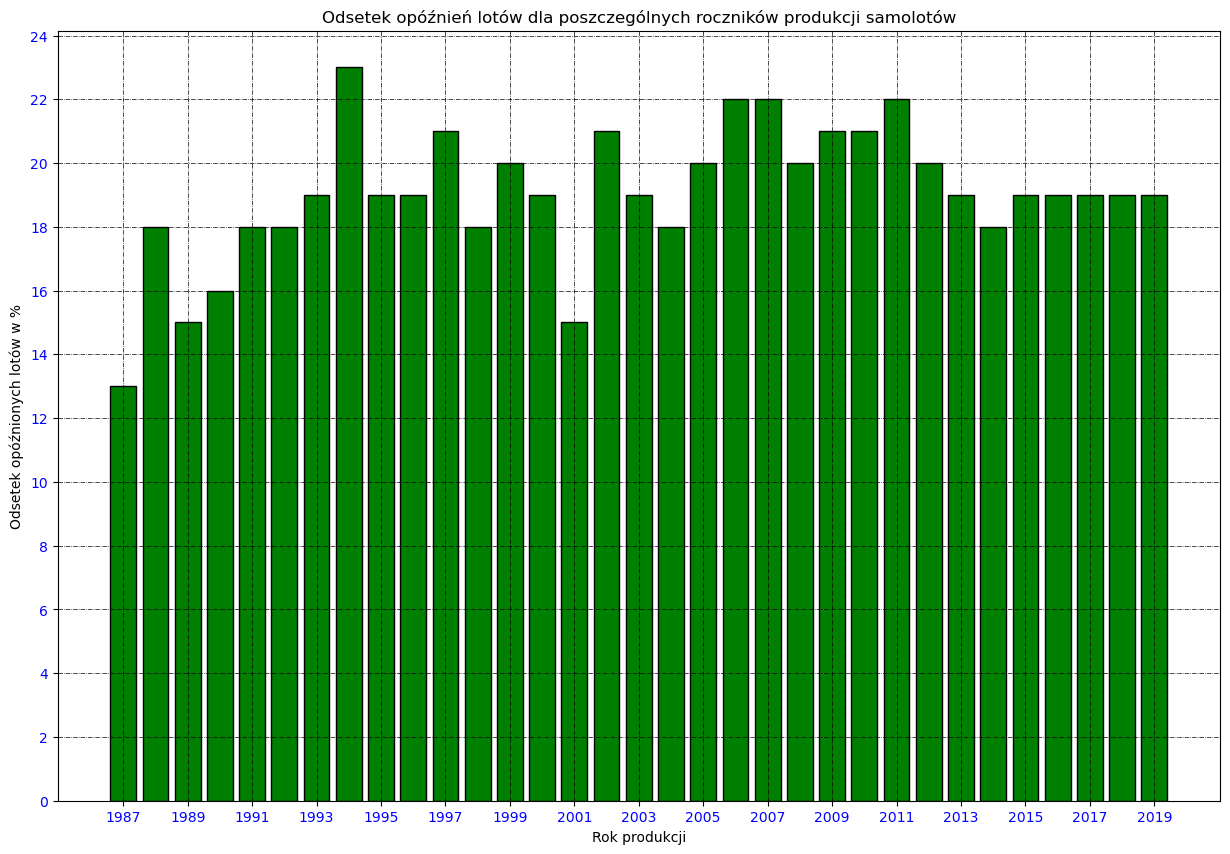

In [35]:
plt.figure(figsize=(15,10))

# Wybranie danych

df = delays_by_manufacture_year_df


x = plt.bar(df['manufacture_year'], df['delays'] * 100,  #  Mnożnik *100, aby uzyskać % jako liczby całkowite
             color="green", edgecolor="Black", log=False, label="Odsetek opóźnień")

plt.ylabel('Odsetek opóźnionych lotów w %')
plt.yticks(ticks=range(0, 26, 2), color="blue")
plt.xlabel('Rok produkcji')
plt.xticks(ticks=range(1987, 2020, 2), color="blue")


plt.title('Odsetek opóźnień lotów dla poszczególnych roczników produkcji samolotów')
plt.grid(which='major', linestyle='-.', linewidth='0.5', color='black')
    
plt.show()

 Modyfikacja wykresu, aby prezentował tylko te roczniki, które odbyły więcej niż 10000 lotów

In [33]:
# Wyznaczenie odsetku opóźnień dla lotów samolotami z poszczególnych lat produkcji:

przedzialy = flight_df['manufacture_year'].unique().tolist()
delayed_column = []
year_column = []

for p in przedzialy:
    temp_df = flight_df.loc[flight_df['manufacture_year'] == p]
    
    # Aby uniknąć dzielenia przez 0:
    if len(temp_df) > 10000:
        temp_result = (temp_df['is_delayed'].count() / len(temp_df)).round(2)
        
        # Dopisanie uzyskanego wyniku do list delayed_column i year_column
        
        delayed_column.append(temp_result)
        year_column.append(p)
    else:
        temp_result = 0

        
# Utworzenie ramki z obu list:

data = {'manufacture_year': year_column, 'delays': delayed_column}    
flight_10000_delays_by_manufacture_year_df = pd.DataFrame(data)

Sporządzenie wykresu na podstawie zmodyfikowanych danych

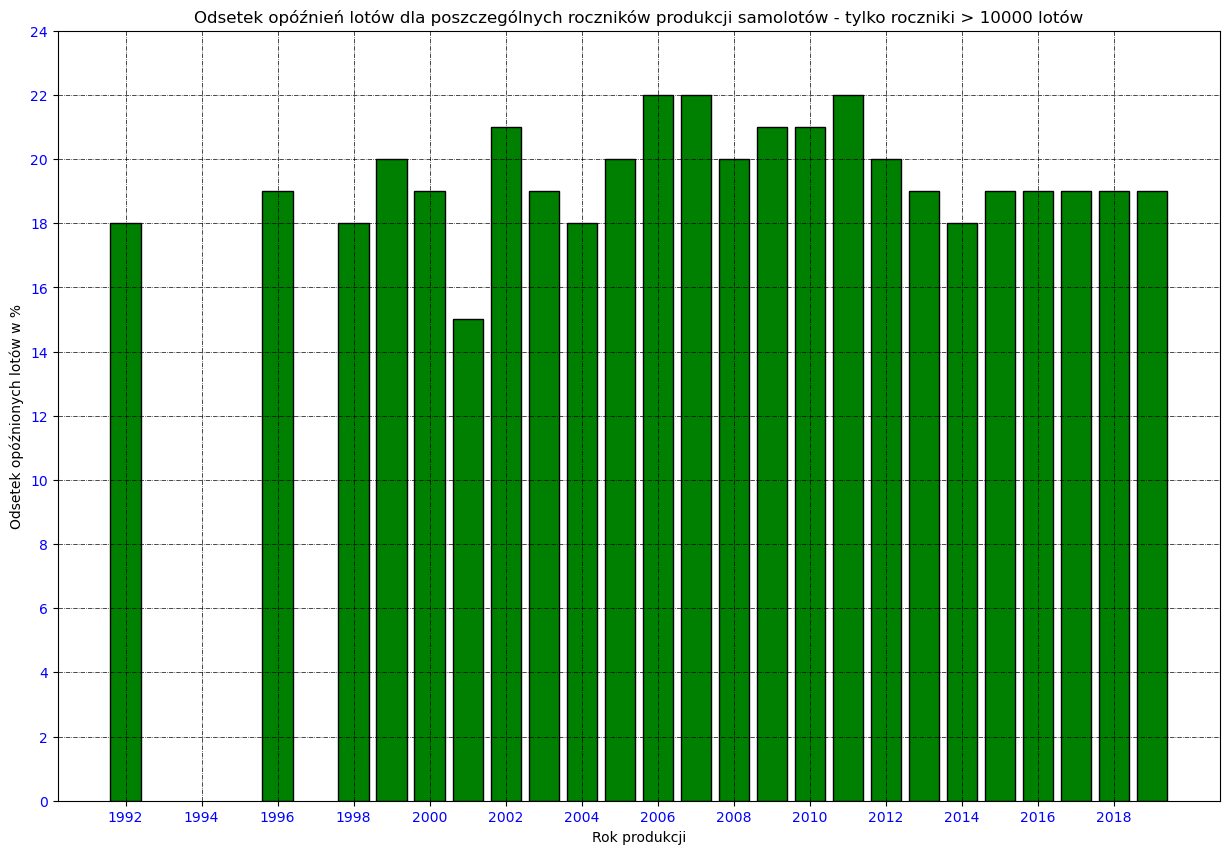

In [38]:
plt.figure(figsize=(15,10))

# Wybranie danych

df = flight_10000_delays_by_manufacture_year_df


x = plt.bar(df['manufacture_year'], df['delays'] * 100, 
             color="green", edgecolor="Black", log=False, label="Odsetek opóźnień")

plt.ylabel('Odsetek opóźnionych lotów w %')
plt.yticks(ticks=range(0, 26, 2), color="blue")
plt.xlabel('Rok produkcji')
plt.xticks(ticks=range(1992, 2020, 2), color="blue")


plt.title('Odsetek opóźnień lotów dla poszczególnych roczników produkcji samolotów - tylko roczniki > 10000 lotów')
plt.grid(which='major', linestyle='-.', linewidth='0.5', color='black')
    
plt.show()

 ## Opóźnienia vs. rok produkcji samolotu cz. 2
 Agregacja kolumny `manufacture_year` do kolumny `manufacture_year_agg` zgodnie z poniższym:
 1. Grupowanie danych co 3 lata -> Czy po grupowaniu można zauważyć zależność? Wyniki zapisz do ramki `flight_delays_by_manufacture_year_agg_df`.
 1. Wyznaczenie top 5 roczników samolotu, które wykonały najwięcej lotów.

 Dodanie kolumny `manufacture_year_agg` do ramki `flight_df`

In [39]:
# Tworzenie kategorii co 3 lata przy użyciu funkcji cut. Max year wynosi 2019, a min 1987, więc ostatnia kategoria to 2020

bins = range(1987, 2020, 3)


# Dodanie kolumny distance_agg

flight_df['manufacture_year_agg'] = pd.cut(flight_df['manufacture_year'], bins)

 Zapis danych do nowej zmiennej: `flight_delays_by_manufacture_year_agg_df`

In [40]:
flight_delays_by_manufacture_year_agg_df = flight_df.copy()

Wyznaczenie TOP 5 roczników produkcji - czyli sortując według liczby wykonanych lotów,

In [41]:
top_manufactured_df = delays_by_manufacture_year_df.sort_values(by=['number_of_travels'], ascending=False).head(5)
top_manufactured_df

,manufacture_year,delays,number_of_travels
3,2001.0,0.15,100251
1,2016.0,0.19,66191
8,2017.0,0.19,62353
17,2014.0,0.18,61128
18,2015.0,0.19,58426


 Zapis uzyskanej ramki do pliku:

In [48]:
flight_df.to_csv(r'C:\Coderslab_Analityk_kurs\Projekt_koncowy\data\processed\flight_df_02.csv', index=False)